In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from fiftyone import ViewField as F
import os
import matplotlib.pyplot as plt
import json
from glob import glob

## Setup

### Step 1: Create a Virtual Environment

Before installing any libraries, it's a good practice to isolate your project dependencies by creating a virtual environment 

 `python3 -m venv kitti-env`

### Step 2: Install Necessary Libraries

1. **Install FiftyOne** 

    `pip install fiftyone`

2. **Install PyTorch**

    `pip install torch torchvision torchaudio`

3. **Install Ultralytics (YOLOv8)**

    `pip install ultralytics`

### Step 3: Verify Installations


In [2]:
# Verify FiftyOne
print(f"FiftyOne version: {fo.__version__}")

# Verify PyTorch
print(f"PyTorch version: {torch.__version__}")

FiftyOne version: 1.1.0
PyTorch version: 2.5.0+cu124


## Load the Virtual KITTI Dataset

Virtual KITTI dataset, a synthetic dataset built upon the renowned KITTI dataset, purposefully designed to support video object detection tasks.

Download the [Dataset](https://europe.naverlabs.com/research/computer-vision/proxy-virtual-worlds-vkitti-2/) for RGB frames and labels text files

To convert the frames into videos, I use ffmpeg on my Linux machine at 10 FPS creating 5-second videos for all different scenes - morning, fog, sunset, overcast, and rain.

I write bash script to create videos and save them into a common folder to integrate it with fifytOne

In [4]:
kitti_data = fo.Dataset.from_videos_dir("./KITTI_videos",name="virtual-kitti-videos")
# kitti_data = fo.load_dataset("kitti-videos")

 100% |█████████████████| 140/140 [106.8ms elapsed, 0s remaining, 1.3K samples/s]  


In [5]:
kitti_data.compute_metadata()
kitti_data

Computing metadata...
 100% |█████████████████| 140/140 [5.3s elapsed, 0s remaining, 30.4 samples/s]      


Name:        virtual-kitti-videos
Media type:  video
Num samples: 140
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
Frame fields:
    id:               fiftyone.core.fields.ObjectIdField
    frame_number:     fiftyone.core.fields.FrameNumberField
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField


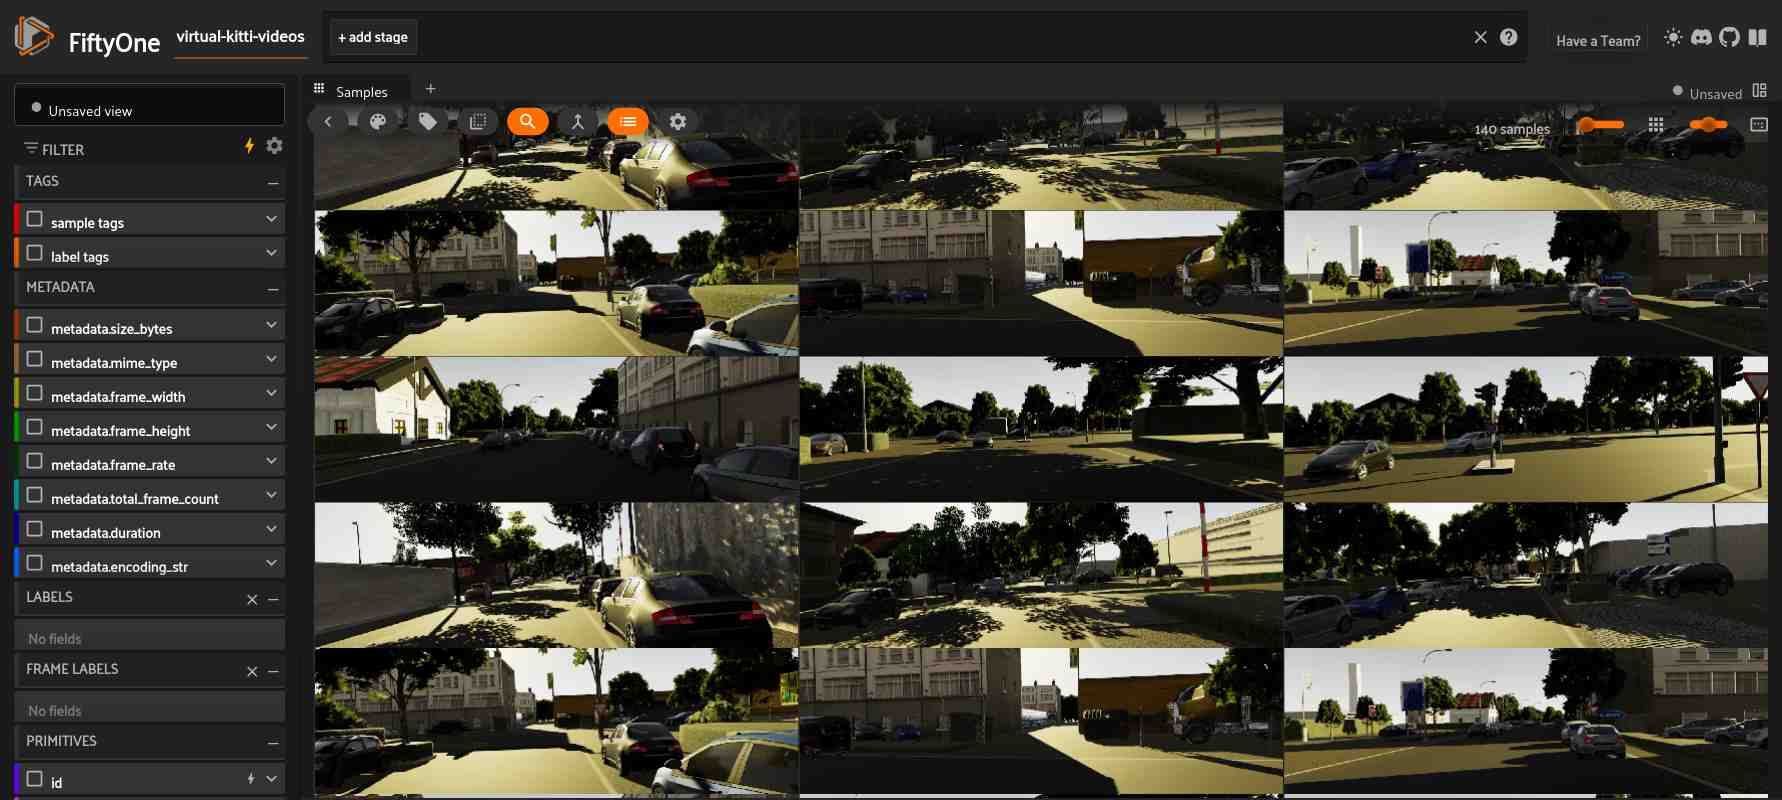

In [6]:
# Launch the FiftyOne app to visualize
session = fo.launch_app(kitti_data)

In [7]:
session.freeze()

 100% |███████████████| 6800/6800 [115.8ms elapsed, 0s remaining, 60.2K samples/s]  
Setting 6800 frame filepaths on the input collection that exist on disk but are not recorded on the dataset



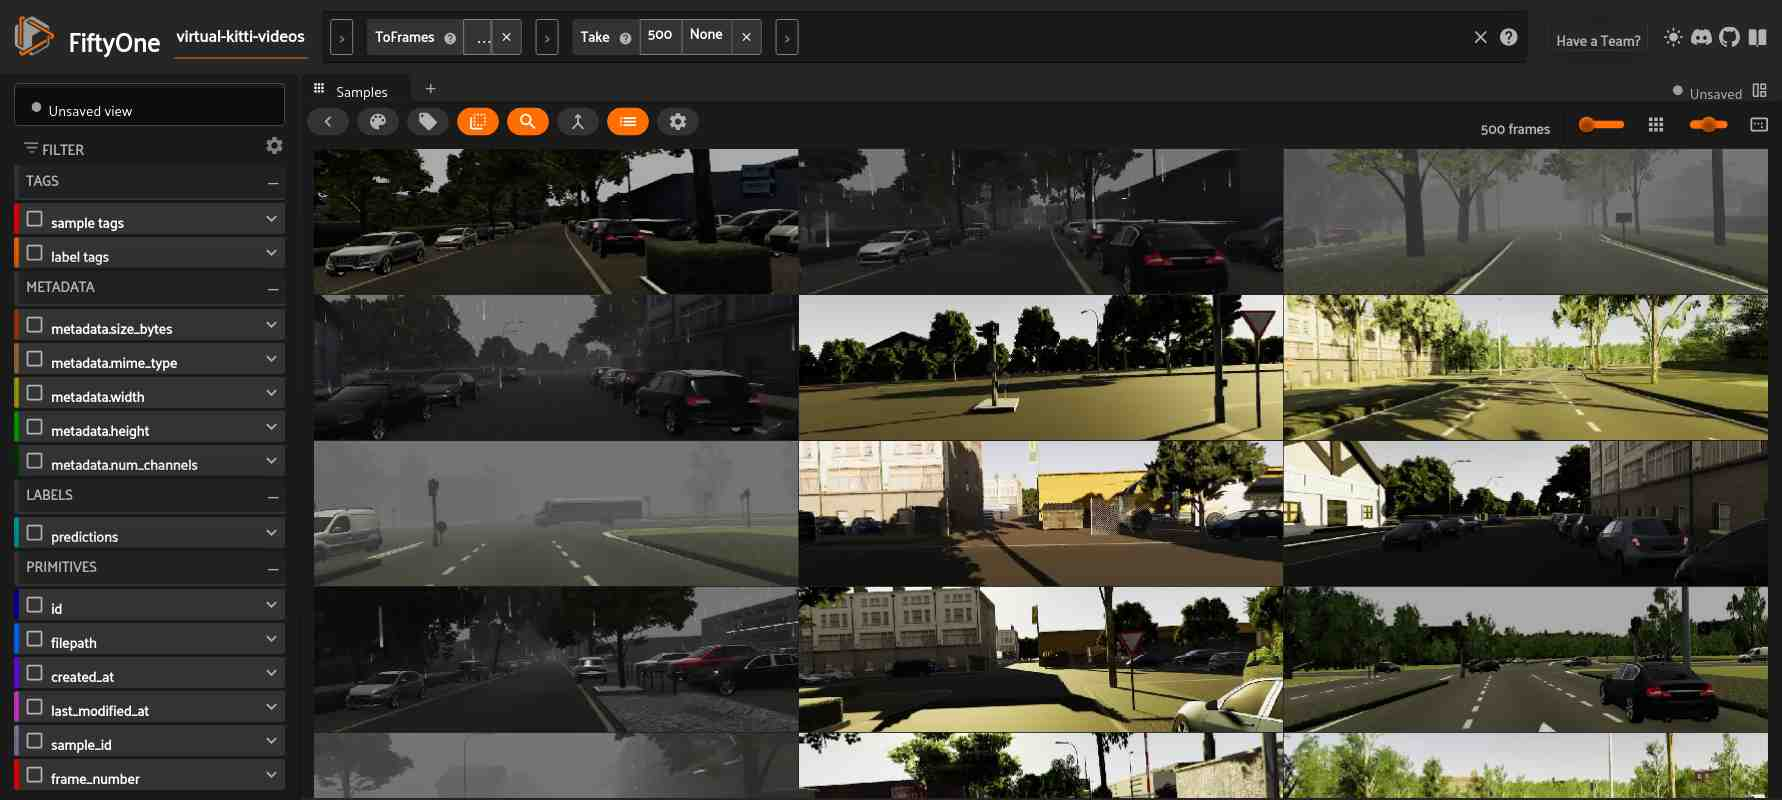

In [15]:
frames = kitti_data.to_frames(sample_frames=True)
view_frames = frames.take(500)
session = fo.launch_app(view_frames)

In [16]:
session.freeze()

## saturation


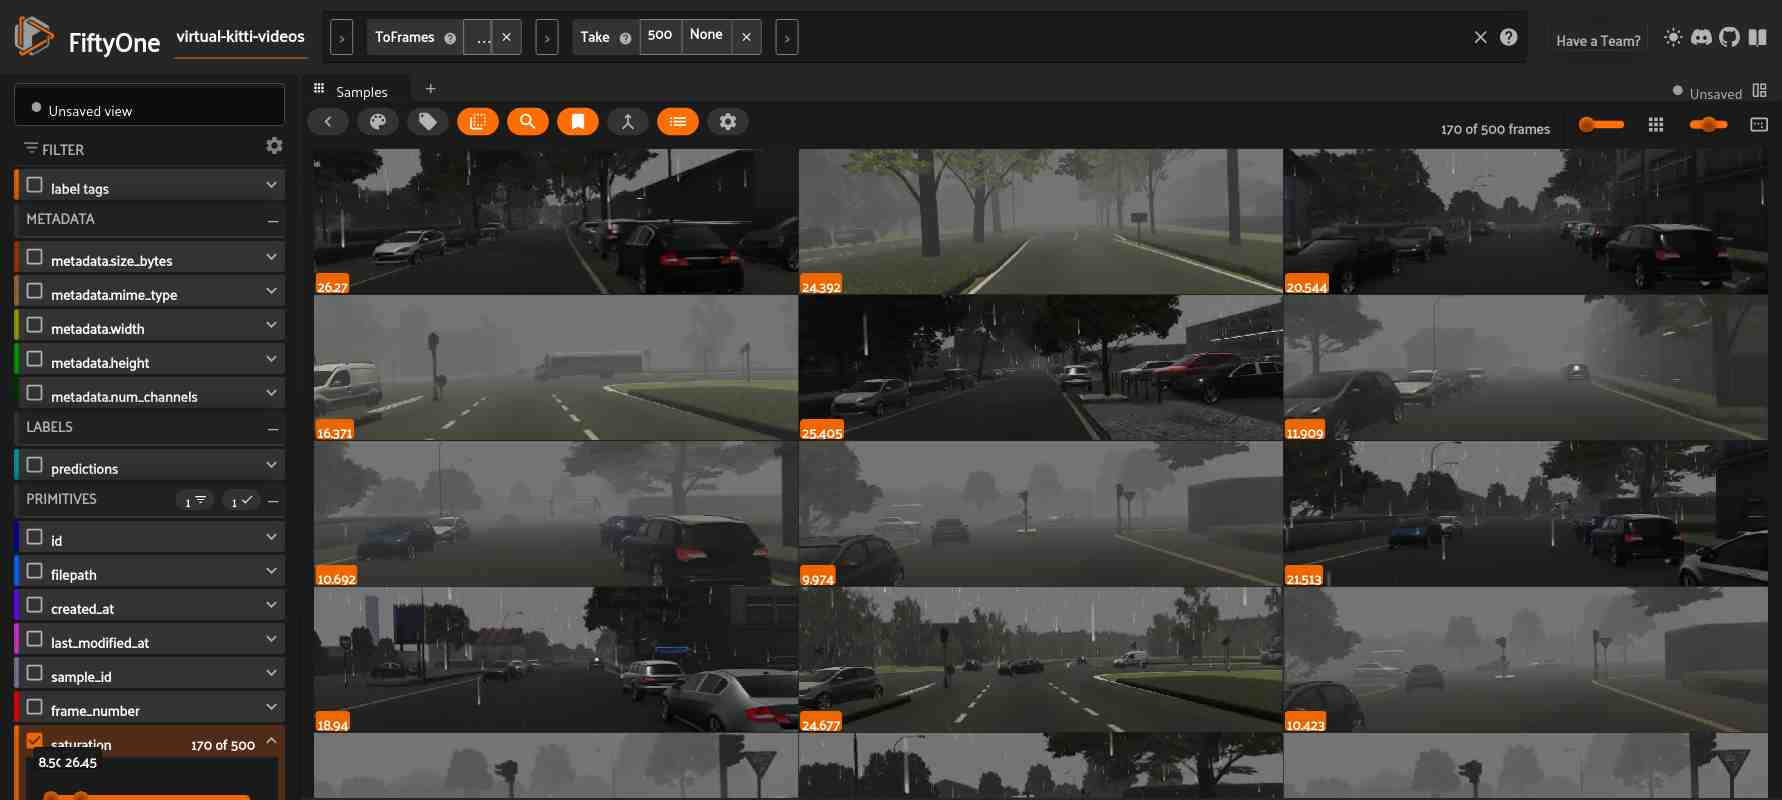

In [17]:
session = fo.launch_app(view_frames)

In [18]:
session.freeze()

## Object detection using Faster RCNN

In [8]:
model = fo.zoo.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")
kitti_data.apply_model(model, label_field="predictions")

 100% |███████████████| 6800/6800 [11.1m elapsed, 0s remaining, 12.6 samples/s]      



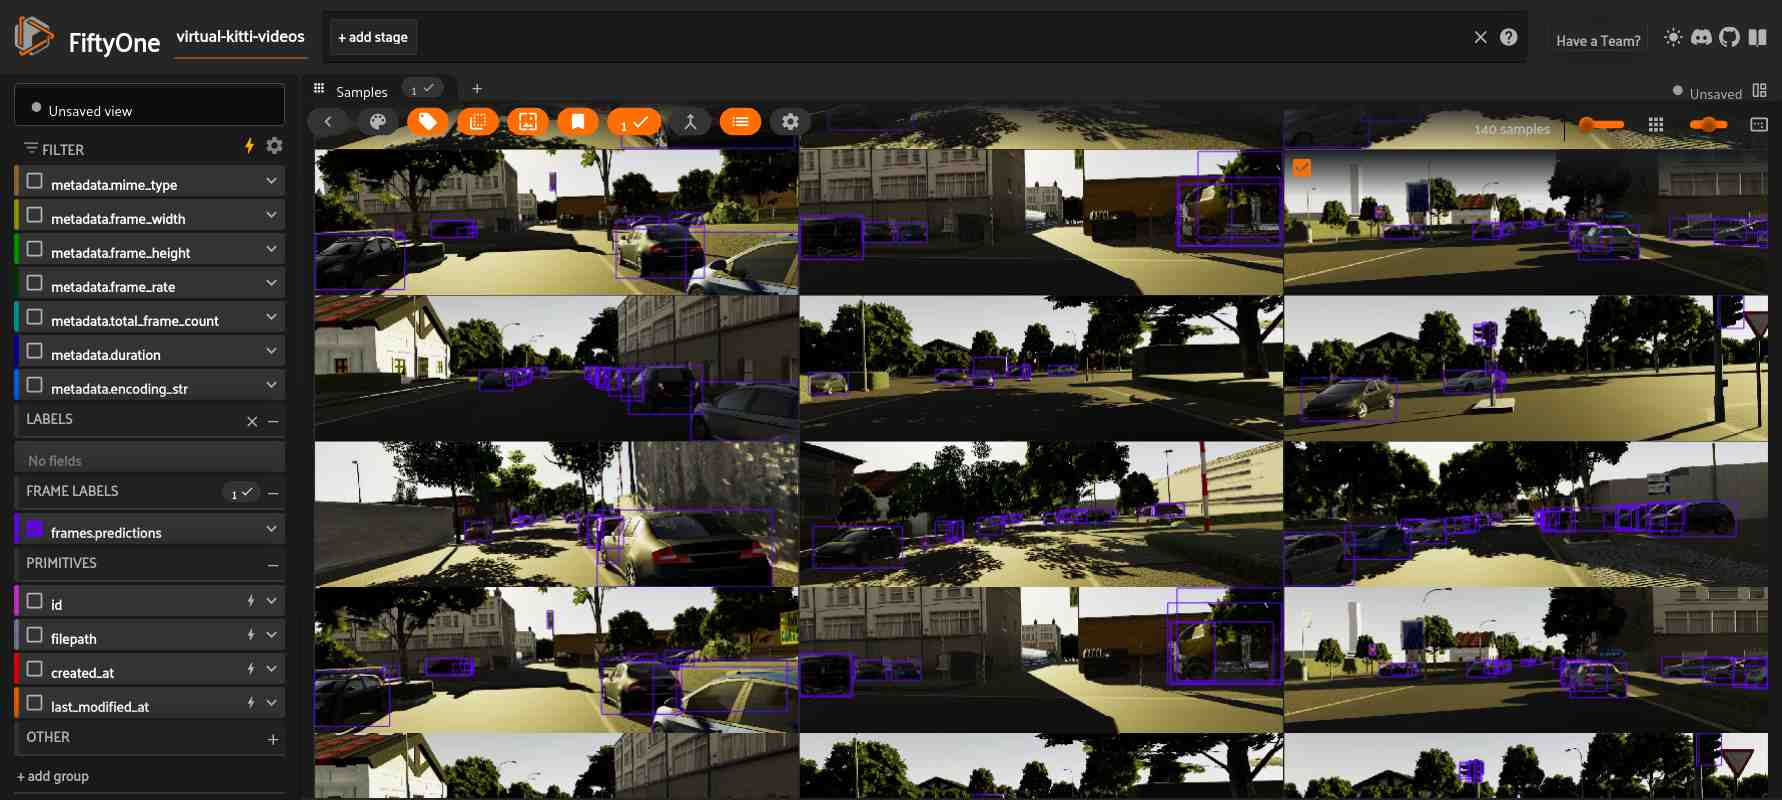

In [12]:
session = fo.launch_app(kitti_data)

In [14]:
session.freeze()

## Analyze objects in frames

In [19]:
frames

Dataset:     virtual-kitti-videos
Media type:  image
Num samples: 6800
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    sample_id:        fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    frame_number:     fiftyone.core.fields.FrameNumberField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    predictions:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. ToFrames(config={'sample_frames': True})

In [ ]:
print("Total frames in KITTI-videos Dataset: ", kitti_data.count("frames")) 
print("Total detected objects in all frames: ", kitti_data.count("frames.predictions.detections"))  

Total frames in KITTI-videos Dataset:  6800
Total detected objects in all frames:  81690


### Predicted objects in 500 frames

In [28]:
count_obj = view_frames.count_values("predictions.detections.label")
count_obj

{'airplane': 8,
 'elephant': 1,
 'truck': 224,
 'person': 144,
 'stop sign': 73,
 'potted plant': 4,
 'bench': 22,
 'bed': 1,
 'traffic light': 521,
 'suitcase': 1,
 'backpack': 1,
 'vase': 1,
 'cake': 1,
 'dining table': 1,
 'car': 4692,
 'parking meter': 48,
 'couch': 2,
 'bottle': 1,
 'chair': 5,
 'fire hydrant': 10,
 'umbrella': 2,
 'skateboard': 1,
 'bird': 3,
 'kite': 7,
 'bus': 56,
 'motorcycle': 5,
 'train': 8,
 'boat': 6,
 'bicycle': 3}

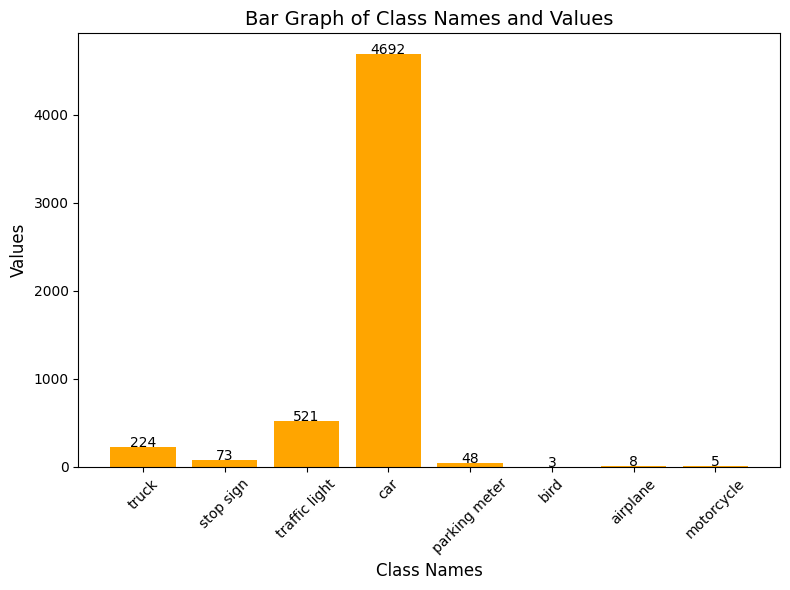

In [31]:
class_names = ['truck', 'stop sign', 'traffic light', 'car', 'parking meter', 'bird', 'airplane', 'motorcycle']
values = [count_obj[key] for key in class_names]

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, values, color='orange')

# Add labels and title
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Bar Graph of Class Names and Values', fontsize=14)
plt.xticks(rotation=45)
# Show value labels on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.5, str(value), ha='center', fontsize=10)

# Display the graph
plt.tight_layout()
plt.show()

### filter labels based on confidence and at least 10 predicted objects

In [35]:
view = view_frames.filter_labels(
    "predictions",
    (F("confidence") > 0.9)
).match(
    F("predictions.detections").length() > 10
)
view

Dataset:     virtual-kitti-videos
Media type:  image
Num samples: 32
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    sample_id:        fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    frame_number:     fiftyone.core.fields.FrameNumberField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    predictions:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. ToFrames(config={'sample_frames': True})
    2. Take(size=500, seed=None)
    3. FilterLabels(field='predictions', filter={'$gt': ['$$this.confidence', 0.9]}, only_matches=True, trajectories=False)
    4. Match(filter={'$expr': {'$gt': [...]}})


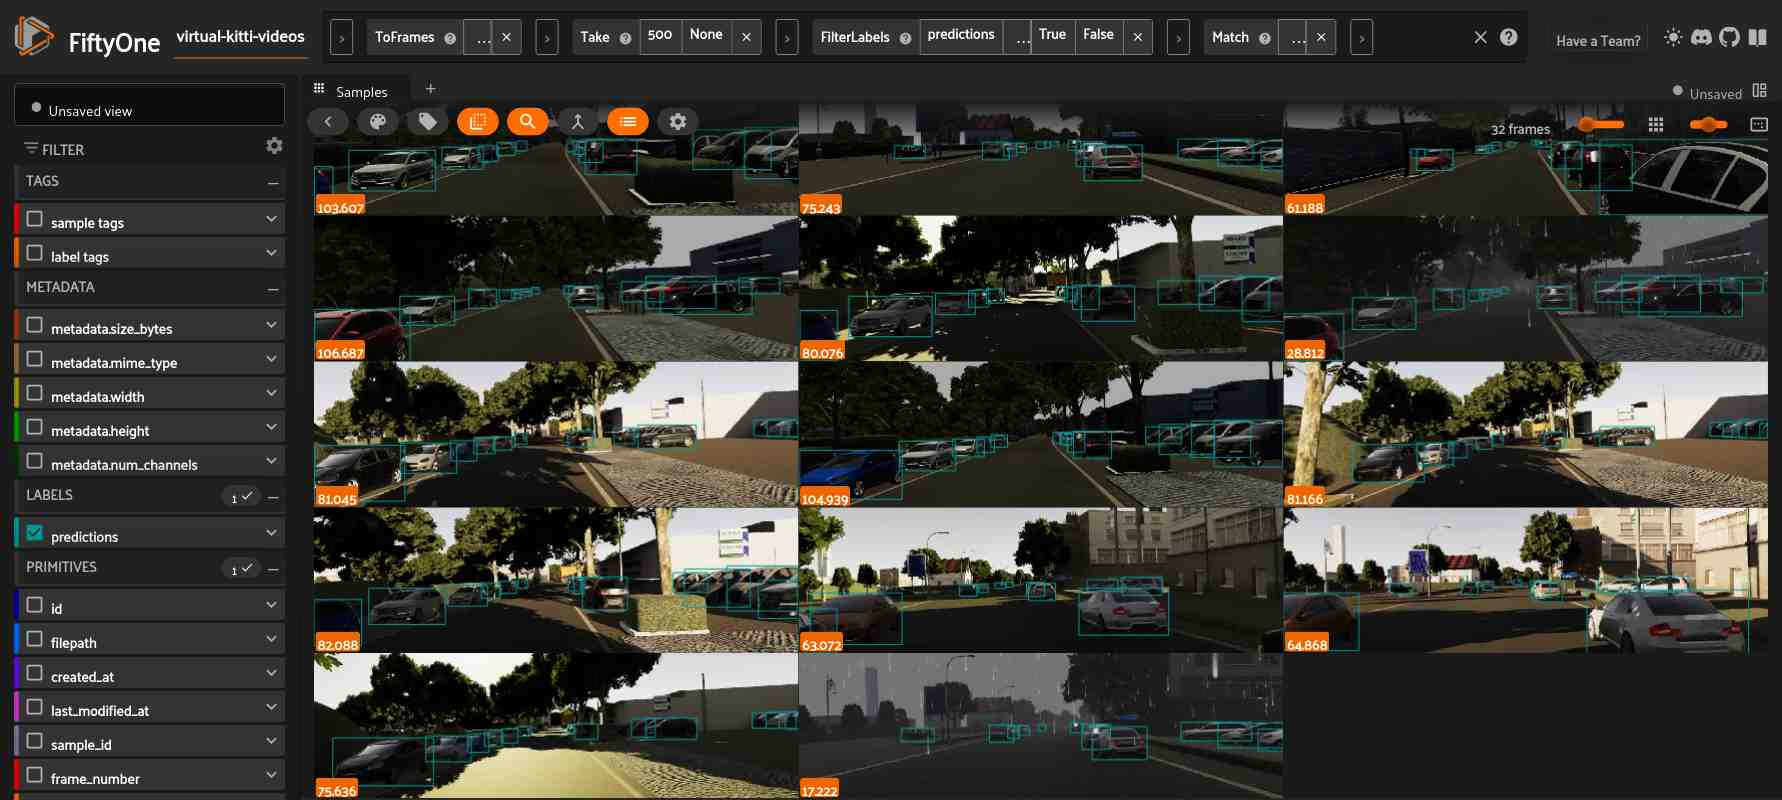

In [36]:
session.view = view

In [37]:
session.freeze()

### Get the distinct labels from predictions

In [40]:
classes = view_frames.distinct("predictions.detections.label")
len(classes)

29

### Get only Truck frames

In [41]:
truck_frames = view_frames.filter_labels('predictions', 
                     (F('confidence') > 0.9) & 
                     (F('label') == "truck")
                     )
truck_frames

Dataset:     virtual-kitti-videos
Media type:  image
Num samples: 26
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    sample_id:        fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    frame_number:     fiftyone.core.fields.FrameNumberField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    predictions:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. ToFrames(config={'sample_frames': True})
    2. Take(size=500, seed=None)
    3. FilterLabels(field='predictions', filter={'$and': [{...}, {...}]}, only_matches=True, trajectories=False)


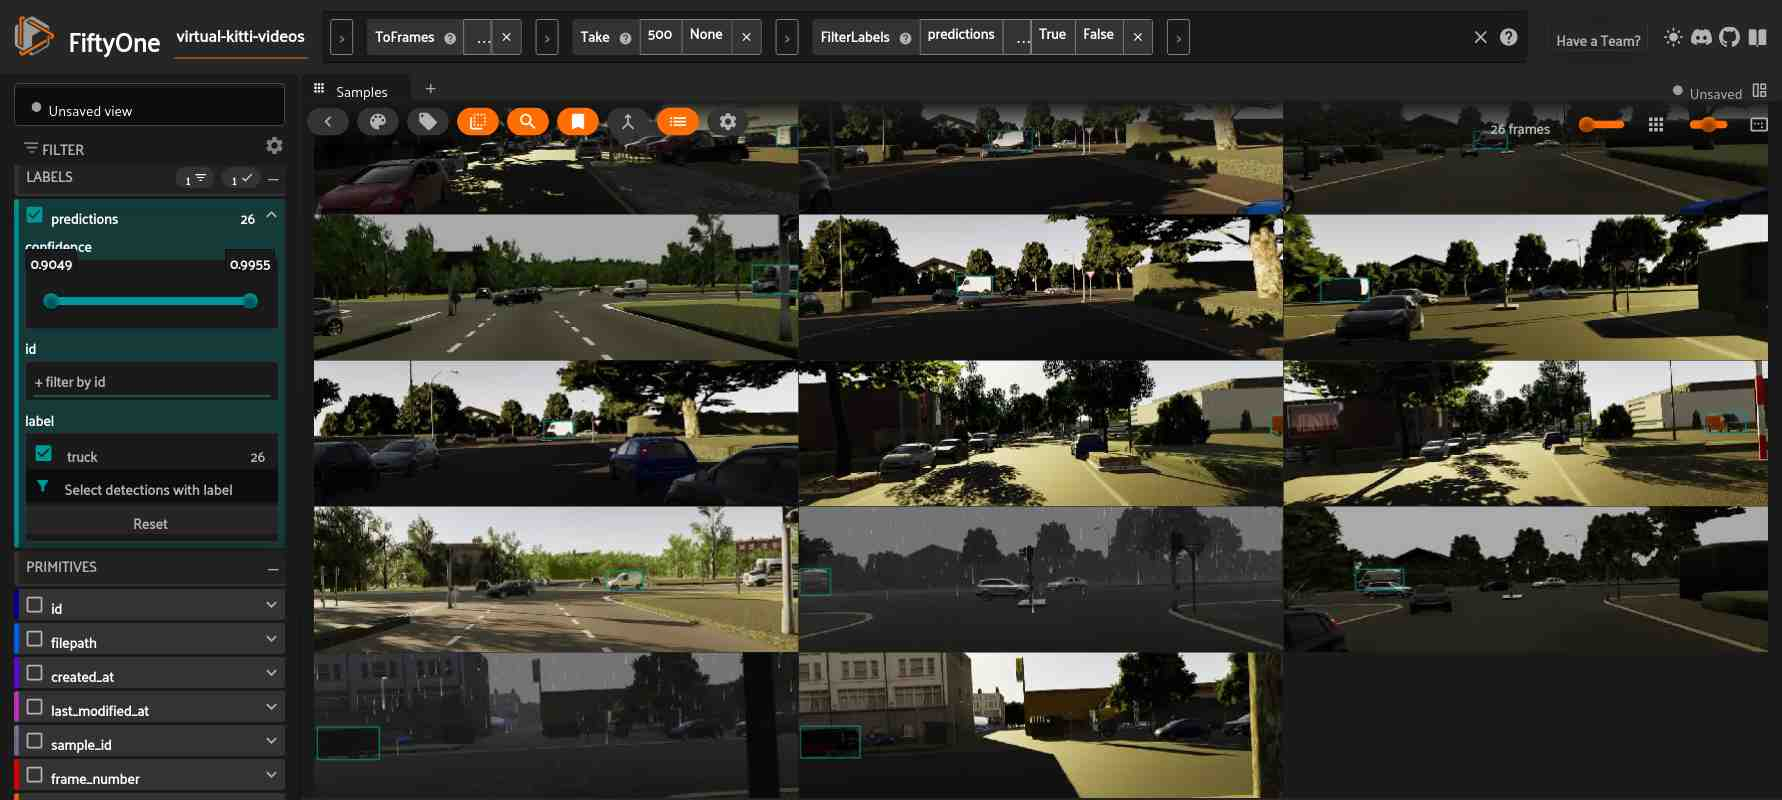

In [42]:
session.view = truck_frames

In [43]:
session.freeze()